In [1]:
import spacy
nlp = spacy.load("it_core_news_sm")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


/home/v.acampora/venv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-07 22:18:05.083241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 22:18:05.717678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
###################### carica dataset LDO 20-21 ############################ 

dataLDO2020 = pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20200101_20210101 pulito.ods', engine='odf')
dataLDO2021=pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20210101_20220101 pulito.ods', engine='odf')


In [3]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
dataLDO2021 = dataLDO2021[dataLDO2021['nosologico'].astype(str).str.contains(r'\d')]
#rimosse 212 righe

In [4]:
print("\nColumns LDO 20-21:", dataLDO2020.columns)
print("\nColumns LDO 21-22:", dataLDO2021.columns)
print("\nShape LDO 20-21:", dataLDO2020.shape)
print("\nShape LDO 21-22:", dataLDO2021.shape)



Columns LDO 20-21: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Columns LDO 21-22: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape LDO 20-21: (24123, 17)

Shape LDO 21-22: (39274, 17)


In [5]:
######################## carica database filtrato ###############################

databaseFiltrato=pd.read_csv('/home/a.renda/to_move/LDO/labeled/20-21_341/DatabaseFiltrato.csv', sep=';')
print(databaseFiltrato.shape)
print(databaseFiltrato.columns) # la prima colonna è solo un contatore

(26237, 3)
Index(['Unnamed: 0', 'nosologico', 'label'], dtype='object')


In [6]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
databaseFiltrato = databaseFiltrato[databaseFiltrato['nosologico'].astype(str).str.contains(r'\d')]

#tolte 5 righe

In [7]:
#################### filtra ldo 2020 ##########################

# Converti la colonna 'nosologico' del secondo dataset in int
databaseFiltrato['nosologico'] = pd.to_numeric(databaseFiltrato['nosologico'], errors='coerce')


# Trova i nosologici comuni
comuni2020 = dataLDO2020['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2020 = dataLDO2020[comuni2020]
print(dataset_filtrato2020.columns)
print(dataset_filtrato2020.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(8974, 17)


In [8]:
####################### filtra ldo 2021 ###########################

# Trova i nosologici comuni
comuni2021 = dataLDO2021['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2021 = dataLDO2021[comuni2021]
print(dataset_filtrato2021.columns)
print(dataset_filtrato2021.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(17218, 17)


In [9]:
######################## merge ldo2020 e ldo 2021 filtrati ###################################

merged_dataset = pd.concat([dataset_filtrato2020, dataset_filtrato2021], ignore_index=True) # non ci sono duplicati tra i due dataset 

# Risultato finale
print("\nColumns merged dataset:",merged_dataset.columns)
print("\nShape merged dataset:",merged_dataset.shape)
print(merged_dataset['testo'][0])



Columns merged dataset: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape merged dataset: (26192, 17)
ObesitÃ  di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesitÃ  di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbiditÃ  e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Gl

In [10]:
######################## carica dataset con nosologici positivi #####################

Positivi= pd.read_excel('/home/a.renda/to_move/LDO/labeled/20-21_341/NosologiciPositivi_341.xlsx')

In [11]:
################################### aggiungere la colonna positivi #########################################

# Convertire la colonna 'Nosologico' in numerico nel dataset NosologiciPositivi
nosologici_positivi = pd.to_numeric(Positivi['NosologiciPositivi'], errors='coerce').dropna()

# Creare la colonna 'positivi' nel DataFrame merged_dataset
merged_dataset['positivi'] = merged_dataset['nosologico'].isin(nosologici_positivi).astype(int)


# Contare quanti 1 e quanti 0 ci sono nella colonna 'positivi'
count_positivi = merged_dataset['positivi'].value_counts()

# Stampa i risultati
print("\nConteggio dei valori nella colonna 'positivi':")
print(f"Numero di 1 (positivi): {count_positivi.get(1, 0)}")
print(f"Numero di 0 (non positivi): {count_positivi.get(0, 0)}")


Conteggio dei valori nella colonna 'positivi':
Numero di 1 (positivi): 341
Numero di 0 (non positivi): 25851


In [12]:
# Unire parole e numeri in 'reparto' rimuovendo lo spazio e sostituendo con un trattino
merged_dataset['reparto'] = merged_dataset['reparto'].str.replace(r'(\w) (\d)', r'\1-\2', regex=True)

# Visualizza i risultati
print(merged_dataset['reparto'].head())

0    UO Endocrinologia-1
1    UO Endocrinologia-1
2    UO Endocrinologia-1
3    UO Endocrinologia-1
4    UO Endocrinologia-1
Name: reparto, dtype: object


In [13]:
###################### pulisci il testo: risoluzione di errori di codifica, sostituzione caratteri speciali #######################
import ftfy

# Applica ftfy.fix_text() a tutte le colonne di testo nel dataset, gestendo i valori non testuali
for col in merged_dataset.select_dtypes(include='object').columns:
    merged_dataset[col] = merged_dataset[col].apply(lambda x: ftfy.fix_text(x) if isinstance(x, str) else x)


In [14]:
########################## PRE-PROCESSING ##########################
############# valutare se il preprocessing deve essere modificato #######################

import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_lg", disable=["parser", "ner"])

# Lista delle colonne su cui applicare il preprocessing
colonne_da_preprocessare = ['testo', 'motivo_ricovero', 'anamnesi', 
                             'esameobiettivo', 'terapiafarmaingresso', 
                             'decorso', 'laboratorio', 'interventi', 
                             'followup', 'terapie2', 'terapie3', 
                             'esami', 'reparto']  # Sostituisci con i nomi reali delle colonne

def clean_token(token):

    # Rimuovi caratteri non alfanumerici (inclusi simboli, punteggiatura, numeri, ecc.) e sostituiscili con uno spazio
    #cleaned_token = re.sub(r'[^a-zA-ZàèéìòùÀÈÉÌÒÙ]', ' ', token)
    cleaned_token = re.sub(r'\s+', ' ', token).strip()  # Normalizza gli spazi multipli

    return cleaned_token

    
# Funzione per tokenizzare e preprocessare il testo
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che il dato sia una stringa valida
        return ""  # Restituisce una stringa vuota se non valido
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /
      
    # Aggiunge spazi tra numeri e lettere (es. "800duloxetina" -> "800 duloxetina")
    row = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', row)
    row = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', row)

    # Aggiunge spazi tra parole composte tipo "vediAllegato" -> "vedi Allegato"
    row = re.sub(r'([a-zàèéìòù])([A-ZÀÈÉÌÒÙ])', r'\1 \2', row)

    # normalizza  spazi (se ci sono più spazi consecutivi, vengono ridotti a uno solo) e rimuove  spazi all'inizio e alla fine della stringa
    #row = re.sub(r'[^\w\s]', ' ', row)  # Rimuove caratteri non alfanumerici e parentesi

    doc = nlp(row)
   
    # Filtra e normalizza i token
    tokens_puliti = [
        clean_token(token.text)
        for token in doc
        #if not token.is_punct and not token.is_stop and len(token.text) > 1 #and token.text.isalpha() 
    ]

    
    # Applica un filtro finale per rimuovere manualmente le lettere singole
    tokens_puliti = [token for token in tokens_puliti if len(token) > 1]  # Assicura che tutte le parole siano > 1 carattere

    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing per ciascuna colonna specificata
for colonna in colonne_da_preprocessare:
    nuova_colonna = f"{colonna}_preprocessed"  # Nome della nuova colonna
    merged_dataset[nuova_colonna] = merged_dataset[colonna].apply(preprocess_text)

# Visualizza i risultati per le nuove colonne preprocessate
print(merged_dataset[[colonna for colonna in colonne_da_preprocessare] + 
                     [f"{col}_preprocessed" for col in colonne_da_preprocessare]])


                                                   testo  \
0      Obesità di classe III complicata da ipertensio...   
1      Carcinoma della tiroide a cellule ossifile (4 ...   
2      Carcinoma papillare differenziato della tiroid...   
3      gozzo multinodulare con quattro focolai di car...   
4      Carcinoma papillare (1,5 cm) variante classica...   
...                                                  ...   
26187  Cistopessi fasciale in paziente con cistocele ...   
26188  Polipectomia resettoscopica, miomectomia reset...   
26189  Laparoscopia, isterectomia sovracervicale, ann...   
26190  Polipectomia resettoscopica in paziente con po...   
26191                                  Mioma sottomucoso   

                                         motivo_ricovero  \
0      Accertamenti in paziente con sangue occulto po...   
1      trattamento radiometabolico con 131-I a dose alta   
2      Terapia radiometabolica con 131-I a scopo adiu...   
3      terapia radiometabolica con 131-

In [15]:
############################ DIMENSIONE VOCABOLARIO ############################
# Calcola il vocabolario
vocab_set = set()
# Itera sulle prime 100 righe delle colonne preprocessate
for colonna in colonne_da_preprocessare:
    for testo in merged_dataset[f"{colonna}_preprocessed"]:  # Limita a 100 righe
        if isinstance(testo, str):  # Assicurati che il testo non sia NaN
            vocab_set.update(testo.split())

# Calcola la dimensione del vocabolario
vocabolario_dimensione = len(vocab_set)
print("Dimensione del vocabolario:", vocabolario_dimensione)

Dimensione del vocabolario: 494115


In [16]:
########################## CLASSIFIERS #################

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Definisci una lista di classificatori che vuoi provare
classifiers = {
    #'RandomForest': RandomForestClassifier(n_jobs=-1, max_depth=10, max_features=0.1, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=3000),
    #'SVM': SVC(probability=True,random_state=42),
    #'KNeighbors': KNeighborsClassifier(),
    #'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
    #'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    #'extremeGradientBoosting': XGBClassifier( learning_rate=0.1, random_state=42, n_jobs=-1, max_depth=6),
}

In [17]:
########################### CROSS VALIDATION #########################

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict


# Funzione modificata per includere la media delle features
def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_f1 = []
    list_auc = []  # Lista per raccogliere i valori di AUC mediati
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold
    
    # Crea una lista per raccogliere precision, recall e f1-score mediati
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    
    # Liste per la deviazione standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    # Inizializza il supporto per ogni classe
    unique_labels = np.unique(y)  # Usa np.unique per gli array NumPy
    support_sum = {str(label): 0 for label in unique_labels}  # Assicurati che le etichette siano stringhe

    for train, val in skf.split(X, y):
        X_tr = X.iloc[train]  # differenza con 'baseline1'
        y_tr = y[train]  # Modifica per lavorare con l'array NumPy
        X_val = X.iloc[val]
        y_val = y[val]  # Modifica per lavorare con l'array NumPy

        # Addestra il pipeline sul training set
        pipeline.fit(X_tr, y_tr)

        # Previsioni sul validation set
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Crea il classification report come dizionario
        cr = classification_report(y_val, y_pred, output_dict=True)

        # Aggiungi il report alla lista
        list_reports.append(cr)

        # Estrai il F1-score
        list_f1.append(cr['weighted avg']['f1-score'])

        # Calcola l'AUC per questo fold
        auc_score = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc_score)

        # Raccogli il numero di features per questo fold
        X_word2vec = pipeline.named_steps['bert'].transform(X_val)  # Modificato per estrarre la trasformazione
        list_num_features.append(X_word2vec.shape[1])  # Numero di features per questo fold

        # Somma le metriche per ogni classe
        for label, metrics in cr.items():
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                precision_sum[label] = precision_sum.get(label, 0) + metrics['precision']
                recall_sum[label] = recall_sum.get(label, 0) + metrics['recall']
                f1_sum[label] = f1_sum.get(label, 0) + metrics['f1-score']

                # Aggiungi valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics['precision']]
                recall_values[label] = recall_values.get(label, []) + [metrics['recall']]
                f1_values[label] = f1_values.get(label, []) + [metrics['f1-score']]

                # Somma il supporto per questa fold
                support_sum[str(label)] += metrics['support']  # Usa str(label) per garantire la corrispondenza

    # Calcola la media dell'AUC
    auc_avg = np.mean(list_auc)

    # Calcola la media del numero di features
    num_features_avg = np.mean(list_num_features)

    # Calcola la media delle metriche per ogni classe
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}

    # Calcola la deviazione standard per ogni metrica
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Calcola il supporto medio per ciascuna classe
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Crea un DataFrame per visualizzare le metriche
    df_avg = pd.DataFrame({
        'Precision': precision_avg,
        'Recall': recall_avg,
        'F1-Score': f1_avg_per_class,
        'Precision Std': precision_std,
        'Recall Std': recall_std,
        'F1-Score Std': f1_std,
        'Support': support_avg,  # Supporto medio
        'Avg Features': num_features_avg,  # Media delle features
    })  # Trasponi per avere le classi come righe

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg 

# Crea un oggetto StratifiedKFold per la cross-validation stratificata
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [18]:
############################### BERT VECTORIZER ###############################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel


# Esegui la cross-validation per ogni classificatore
columns_to_vectorize = ['testo_preprocessed', 'motivo_ricovero_preprocessed', 'anamnesi_preprocessed', 
                             'esameobiettivo_preprocessed', 'terapiafarmaingresso_preprocessed', 
                             'decorso_preprocessed', 'laboratorio_preprocessed', 'interventi_preprocessed', 
                             'followup_preprocessed', 'terapie2_preprocessed', 'terapie3_preprocessed', 
                             'esami_preprocessed', 'reparto_preprocessed']

X = merged_dataset[columns_to_vectorize]  # Passa l'intero dataset, con le 13 colonne
y = merged_dataset['positivi']
# Converti le etichette in numeri con LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)  # Trasforma le etichette in numeri

# Carica il tokenizzatore e il modello di BERT
model_name = "dbmdz/bert-base-italian-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name, max_length=512, device=None):
        """
        Inizializza il trasformatore BERT.
        
        :param model_name: Il nome del modello BERT pre-addestrato.
        :param max_length: La lunghezza massima per il padding delle sequenze di input.
        :param device: Il dispositivo da usare ('cuda' o 'cpu'). Se None, viene scelto automaticamente.
        """
        self.model_name = model_name 
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.max_length = max_length
        self.device = device or ('cuda:2' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def fit(self, X, y=None):
        """Metodo di fitting (non necessario per il trasformatore)."""
        return self

    def transform(self, X, batch_size=32):
        """
        Applica la trasformazione ai dati di input in batch.
        """
        # Prepara i dati
        if isinstance(X, pd.DataFrame):
            texts = X.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1).tolist()
        elif isinstance(X, pd.Series):
            texts = X.dropna().astype(str).tolist()
        else:
            raise ValueError("ClinicalBertTransformer accetta solo input di tipo DataFrame o Series.")

        embeddings = []

        # Elaborazione a batch
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            input_ids = []
            attention_masks = []

            for text in batch_texts:
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_length,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                )
                input_ids.append(encoding['input_ids'])
                attention_masks.append(encoding['attention_mask'])

            input_ids = torch.cat(input_ids, dim=0).to(self.device)
            attention_masks = torch.cat(attention_masks, dim=0).to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_masks)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

        # Concatena tutti i batch
        return np.vstack(embeddings)


### Modello: LogisticRegression ###


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.

Dimensione della matrice Bert: 26192 campioni, 768 features


/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad

Classification report mediato:
   Precision    Recall  F1-Score  Precision Std  Recall Std  F1-Score Std  \
0   0.987203  0.999652  0.993388       0.000345    0.000321      0.000153   
1   0.193333  0.017563  0.031751       0.244404    0.026921      0.047453   

   Support  Avg Features  
0   2585.1         768.0  
1     34.1         768.0  
AUC medio: 0.7646
Numero medio di features: 768.00


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.

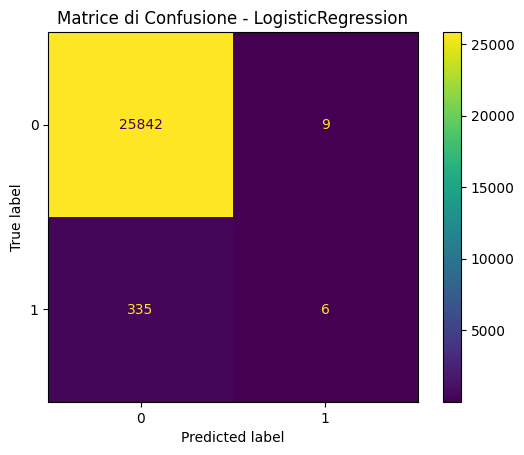

In [22]:
############################### BERT VECTORIZER ###############################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel


# Esegui la cross-validation per ogni classificatore
columns_to_vectorize = ['testo_preprocessed', 'motivo_ricovero_preprocessed', 'anamnesi_preprocessed', 
                             'esameobiettivo_preprocessed', 'terapiafarmaingresso_preprocessed', 
                             'decorso_preprocessed', 'laboratorio_preprocessed', 'interventi_preprocessed', 
                             'followup_preprocessed', 'terapie2_preprocessed', 'terapie3_preprocessed', 
                             'esami_preprocessed', 'reparto_preprocessed']

X = merged_dataset[columns_to_vectorize]  # Passa l'intero dataset, con le 13 colonne
y = merged_dataset['positivi']
# Converti le etichette in numeri con LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)  # Trasforma le etichette in numeri

# Carica il tokenizzatore e il modello di BERT
model_name = "dbmdz/bert-base-italian-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name, max_length=512, device=None):
        """
        Inizializza il trasformatore BERT.
        
        :param model_name: Il nome del modello BERT pre-addestrato.
        :param max_length: La lunghezza massima per il padding delle sequenze di input.
        :param device: Il dispositivo da usare ('cuda' o 'cpu'). Se None, viene scelto automaticamente.
        """
        self.model_name = model_name 
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.max_length = max_length
        self.device = device or ('cuda:2' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def fit(self, X, y=None):
        """Metodo di fitting (non necessario per il trasformatore)."""
        return self

    def transform(self, X, batch_size=32):
        """
        Applica la trasformazione ai dati di input in batch.
        """
        # Prepara i dati
        if isinstance(X, pd.DataFrame):
            texts = X.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1).tolist()
        elif isinstance(X, pd.Series):
            texts = X.dropna().astype(str).tolist()
        else:
            raise ValueError("ClinicalBertTransformer accetta solo input di tipo DataFrame o Series.")

        embeddings = []

        # Elaborazione a batch
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            input_ids = []
            attention_masks = []

            for text in batch_texts:
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_length,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                )
                input_ids.append(encoding['input_ids'])
                attention_masks.append(encoding['attention_mask'])

            input_ids = torch.cat(input_ids, dim=0).to(self.device)
            attention_masks = torch.cat(attention_masks, dim=0).to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_masks)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

        # Concatena tutti i batch
        return np.vstack(embeddings)


for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")
    
    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
    ('bert', BertTransformer(model_name)),  # Il tuo trasformatore basato su BERT
    ('classificazione', clf)  # Il tuo classificatore (ad esempio Random Forest)
])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Trasforma i dati e ottieni la dimensione
    X_word2vec = pipeline.named_steps['bert'].transform(X)
    num_samples, num_features = X_word2vec.shape
    print(f"Dimensione della matrice Bert: {num_samples} campioni, {num_features} features")

    # Calcola le metriche usando la funzione
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")
    
    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)
    
    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()

In [23]:
############################ CALCOLO OOV ###########################

from transformers import BertTokenizer
from collections import Counter

def calculate_oov_percentage(texts, tokenizer, global_oov_counter, global_valid_words):
    """
    Calcola la percentuale di parole OOV usando il tokenizer di BERT.
    
    :param texts: Lista di testi (singola colonna o una lista di colonne).
    :param tokenizer: Tokenizer pre-addestrato BERT.
    :param global_oov_counter: Un contatore globale per le parole OOV.
    :param global_valid_words: Un set globale di parole valide.
    :return: Percentuale di OOV e statistiche globali.
    """
    total_words = 0
    oov_words = 0

    for text in texts:
        # Suddividi il testo in parole
        words = text.split()
        total_words += len(words)
        
        for word in words:
            # Tokenizza ogni parola
            tokens = tokenizer.tokenize(word)
            if len(tokens) > 1 or (len(tokens) == 1 and tokens[0] == '[UNK]'):
                # Conta come OOV se suddivisa in più token o è [UNK]
                oov_words += 1
                global_oov_counter[word] += 1  # Aggiungi alla conta globale degli OOV
            else:
                global_valid_words.add(word)  # Aggiungi alla lista delle parole valide
    
    # Calcola la percentuale di OOV
    oov_percentage = (oov_words / total_words) * 100 if total_words > 0 else 0
    return oov_words, total_words, oov_percentage

# Carica il tokenizzatore e il modello di BERT
model_name = "dbmdz/bert-base-italian-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Contatori globali
global_oov_counter = Counter()  # Per tenere traccia delle parole OOV globali
global_valid_words = set()  # Per tenere traccia delle parole valide globali

# Se hai un DataFrame, applica la funzione per ciascuna colonna
all_oov_words = 0
all_total_words = 0

for col in X.columns:
    print(f"Calcolando OOV per la colonna: {col}")
    texts = X[col].dropna().astype(str).tolist()  # Assicurati che i dati siano in formato stringa
    oov_words, total_words, oov_percentage = calculate_oov_percentage(texts, tokenizer, global_oov_counter, global_valid_words)
    
    # Aggiorna i contatori globali
    all_oov_words += oov_words
    all_total_words += total_words

    print(f"Parole OOV nella colonna '{col}': {oov_words}, Totale parole: {total_words}, Percentuale OOV: {oov_percentage:.2f}%")

# Calcolo delle statistiche globali
total_unique_words = len(global_valid_words) + len(global_oov_counter)
oov_percentage_global = (len(global_oov_counter) / total_unique_words) * 100 if total_unique_words > 0 else 0

# Risultati globali
print("\n### Statistiche globali ###")
print(f"Totale parole valide uniche: {len(global_valid_words)}")
print(f"Totale parole OOV uniche: {len(global_oov_counter)}")
print(f"Totale parole uniche (valide + OOV): {total_unique_words}")
print(f"Percentuale globale di parole OOV: {oov_percentage_global:.2f}%")

# Stampa le prime 50 parole OOV globali
print("\nPrime 50 parole OOV globali ordinate per frequenza:")
for i, (word, count) in enumerate(global_oov_counter.most_common(100)):
    print(f"{i+1}. {word}: {count}")

Calcolando OOV per la colonna: testo_preprocessed
Parole OOV nella colonna 'testo_preprocessed': 343325, Totale parole: 676517, Percentuale OOV: 50.75%
Calcolando OOV per la colonna: motivo_ricovero_preprocessed
Parole OOV nella colonna 'motivo_ricovero_preprocessed': 141497, Totale parole: 325730, Percentuale OOV: 43.44%
Calcolando OOV per la colonna: anamnesi_preprocessed
Parole OOV nella colonna 'anamnesi_preprocessed': 2773833, Totale parole: 7025366, Percentuale OOV: 39.48%
Calcolando OOV per la colonna: esameobiettivo_preprocessed
Parole OOV nella colonna 'esameobiettivo_preprocessed': 557349, Totale parole: 1216145, Percentuale OOV: 45.83%
Calcolando OOV per la colonna: terapiafarmaingresso_preprocessed
Parole OOV nella colonna 'terapiafarmaingresso_preprocessed': 181218, Totale parole: 415903, Percentuale OOV: 43.57%
Calcolando OOV per la colonna: decorso_preprocessed
Parole OOV nella colonna 'decorso_preprocessed': 1787938, Totale parole: 5875979, Percentuale OOV: 30.43%
Calco

In [ ]:
#################################### SMOTE ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('bert', BertTransformer(model_name)),
        ('smote', SMOTE(random_state=42)),
        ('classificazione', clf)
    ])

    X = merged_dataset[columns_to_vectorize]  # Passa l'intero dataset, con le 13 colonne
    y = merged_dataset['positivi']

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: LogisticRegression ###


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/v.acampora/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.

In [ ]:
#################################### SMOTE + UNDERSAMPLING ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
        ('bert', BertTransformer(model_name))
        ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
        ('undersample', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
        ('classificazione', clf)
    ])

    X = merged_dataset[columns_to_vectorize]  # Passa l'intero dataset, con le 13 colonne
    y = merged_dataset['positivi']

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()
